In [92]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(1)
from tqdm import tqdm
import yaml
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)

from concurrent.futures import ProcessPoolExecutor, as_completed
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.8f}'.format})


In [93]:
#read FATS for OGLE3 light curves 
df_ogle = pd.read_csv('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/OGLE_DR3_2024.csv')

In [94]:
# Remove the '.dat' extension
df_ogle['cleaned_ID'] = df_ogle['ID'].str.replace('.dat', '')

# Split the column into four new columns
df_ogle[['survey', 'field', 'star_type', 'id_number']] = df_ogle['cleaned_ID'].str.split('-', expand=True)


# select star types that will be included in our model
df_ogle_dr3 = df_ogle[df_ogle.star_type.isin(['RRLYR', 'CEP', 'ECL', 'LPV', 'DSCT'])]


# check star types
print(df_ogle_dr3.star_type.unique())

print(df_ogle_dr3.shape)

# Select only the numeric columns
numeric_df = df_ogle_dr3.select_dtypes(include=[np.number])

# Identify rows with infinity values in numeric columns
inf_mask = np.isinf(numeric_df).any(axis=1)

# Drop rows with any infinity values
df_ogle_dr3 = df_ogle_dr3[~inf_mask].reset_index(drop=True)

df_ogle_dr3.dropna(inplace=True)

print(df_ogle_dr3.shape)

['ECL' 'RRLYR' 'CEP' 'LPV' 'DSCT']
(419257, 70)
(419257, 70)


In [95]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']
PATH_LIGHT_CURVES_OGLE = PATHS['PATH_LIGHT_CURVES_OGLE']

df_ogle_dr3['number_of_observations'] = 0

def process_light_curve(lc):
    path_lc = PATH_LIGHT_CURVES_OGLE + lc.split('-')[1].lower() + '/' + lc.split('-')[2].lower() + '/phot/I/' + lc
    lcu = pd.read_table(path_lc, sep=" ", names=['time', 'magnitude', 'error'])
    return lc, lcu.shape[0]

# Collecting results in a dictionary for batch updating
results_dict = {}


def process_light_curve(lc):
    path_lc = PATH_LIGHT_CURVES_OGLE + lc.split('-')[1].lower() + '/' + lc.split('-')[2].lower() + '/phot/I/' + lc
    lcu = pd.read_table(path_lc, sep=" ", names=['time', 'magnitude', 'error'])
    return lc, lcu.shape[0]

with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(process_light_curve, lc): lc for lc in df_ogle_dr3.ID.unique()}
    for future in tqdm(as_completed(futures), total=len(futures), desc='Processing Light Curves'):
        lc, number_of_observations = future.result()
        results_dict[lc] = number_of_observations

# Applying all updates at once to the DataFrame
df_ogle_dr3['number_of_observations'] = df_ogle_dr3['ID'].map(results_dict)


Processing Light Curves: 100%|██████████| 419257/419257 [01:44<00:00, 4025.03it/s]


In [96]:
# remove columns which wont be used as features  
df_ogle_dr3 = df_ogle_dr3.drop(axis='columns', columns=['cleaned_ID', 'survey', 'id_number', 'field', 'ID'])


In [97]:
# copy the df to be used to train a classifier
df_to_train = df_ogle_dr3.copy()

# define the label that will be provided to the classifier
label = df_to_train['star_type']

# delete the label from the trainig set
del df_to_train['star_type']

# create a ranfom forest classifier
clf = RandomForestClassifier(max_depth=12, random_state=0)

# fit the classifier
clf.fit(df_to_train, label)

# obtain soft predictions for each star
soft_prediction =  clf.predict_proba(df_to_train)

soft_prediction

array([[0.00182392, 0.00208223, 0.98515030, 0.00195377, 0.00898979],
       [0.06675628, 0.00088638, 0.00324329, 0.00022843, 0.92888562],
       [0.23505251, 0.00081218, 0.00252058, 0.00074314, 0.76087158],
       ...,
       [0.00030946, 0.00002250, 0.00227443, 0.99728190, 0.00011172],
       [0.00061982, 0.00000414, 0.00115480, 0.99758750, 0.00063374],
       [0.00019285, 0.00004427, 0.00112546, 0.99852349, 0.00011393]])

In [98]:
# prediction example
print(soft_prediction[0])
print(clf.classes_)

[0.00182392 0.00208223 0.98515030 0.00195377 0.00898979]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [99]:
soft_prediction.shape

(419257, 5)

In [100]:
# prediction example
print(soft_prediction[1])
print(clf.classes_)

[0.06675628 0.00088638 0.00324329 0.00022843 0.92888562]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [101]:
# prediction example
print(soft_prediction[2])
print(clf.classes_)

[0.23505251 0.00081218 0.00252058 0.00074314 0.76087158]
['CEP' 'DSCT' 'ECL' 'LPV' 'RRLYR']


In [102]:
# Assign the soft predictions to the training set
df_to_train[['soft_pred_cep', 'soft_pred_dsct', 'soft_pred_ecl', 'soft_pred_lpv', 'soft_pred_rrlyr']] = soft_prediction

# Create the squared columns using vectorized operations
soft_pred_columns = ['soft_pred_cep', 'soft_pred_dsct', 'soft_pred_ecl', 'soft_pred_lpv', 'soft_pred_rrlyr']
df_to_train[[col + '_2' for col in soft_pred_columns]] = df_to_train[soft_pred_columns] ** 2

# Calculate the 'h' column, which quantifies the classification hardness for each star.
# This metric is derived from the multi-class extension of the Gini impurity index.
# The 'h' value represents the level of uncertainty or difficulty in classifying each star.
# Values close to 0 indicate that the star is likely to belong to a single class with high confidence,
# while higher values suggest more uncertainty, with the star having non-negligible probabilities across multiple classes.
df_to_train['h'] = 1 - df_to_train[[col + '_2' for col in soft_pred_columns]].sum(axis=1)


In [103]:
df_ogle = df_ogle[df_ogle.star_type.isin(['RRLYR', 'CEP', 'ECL', 'LPV', 'DSCT'])]

In [104]:
# Set the bias factor (T controls the strength of the bias)
T = 3.0

# Calculate a bias factor based on the hardness score 'h'
# The hardness score 'h' determines how challenging it is to classify each star.
# Multiplying 'h' by T scales the bias factor accordingly.
factor = T * df_to_train['h']

# Compute the exponential of the negative bias factor
# This step creates a probability-like value 'e' that decreases as the hardness 'h' increases.
# Stars that are harder to classify (higher 'h') will have lower 'e' values, leading to a higher chance of being excluded from the training set.
df_to_train['e'] = np.exp(-factor)

# Generate a random uniform value 'u' for each star between 0 and 1
# This random value is used to introduce stochasticity into the selection process.
df_to_train['u'] = np.random.uniform(0, 1, df_to_train.shape[0])

# Assign label, field, and ID columns from another DataFrame to df_to_train
# This step is for associating metadata with each star in the dataset.
df_to_train[['label', 'field', 'ID']] = pd.DataFrame({
    'label': label,
    'field': df_ogle['field'].values,
    'ID': df_ogle['ID'].values
})

# Select stars for the test set where 'e' is less than or equal to 'u'
# Stars with higher hardness (low 'e') are more likely to end up in the test set,
# meaning the test set will contain more challenging examples, thus inducing bias.
data_test = df_to_train[df_to_train['e'] <= df_to_train['u']]
print(data_test.shape)
print(data_test.label.value_counts())

# Select stars for the training set where 'e' is greater than 'u'
# Stars that are easier to classify (high 'e') are more likely to remain in the training set,
# leading to a biased training set that consists of easier-to-classify examples.
data_train = df_to_train[df_to_train['e'] > df_to_train['u']]
print(data_train.shape)
print(data_train.label.value_counts())


(28450, 81)
RRLYR    8589
LPV      7886
ECL      7135
CEP      3480
DSCT     1360
Name: label, dtype: int64
(390807, 81)
LPV      316092
ECL       34652
RRLYR     34144
CEP        4472
DSCT       1447
Name: label, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


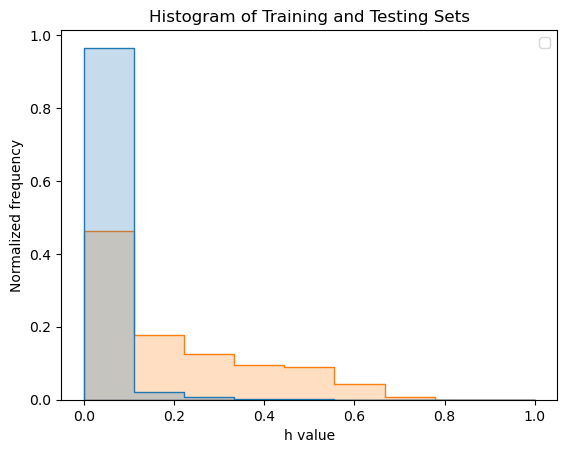

In [105]:
#sets up the axis and gets histogram data
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming data_train.h and data_test.h are your datasets

# Create a DataFrame for easier handling with Seaborn
df_train = pd.DataFrame({'h': data_train.h, 'set': 'Training set'})
df_test = pd.DataFrame({'h': data_test.h, 'set': 'Testing set'})

# Combine both DataFrames
df = pd.concat([df_train, df_test])

# Plot using Seaborn
sns.histplot(data=df, x='h', hue='set', bins=np.linspace(0, 1, 10), stat="probability", element="step", common_norm=False)

# Customize the plot
plt.legend(loc='upper right')
plt.xlabel('h value')
plt.ylabel('Normalized frequency')
plt.title('Histogram of Training and Testing Sets')
plt.show()

In [106]:
data_train.columns

Index(['Unnamed: 0', 'Amplitude', 'AndersonDarling', 'Autocor_length',
       'Beyond1Std', 'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0',
       'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
       'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0',
       'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2',
       'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq

In [107]:
data_train.columns

Index(['Unnamed: 0', 'Amplitude', 'AndersonDarling', 'Autocor_length',
       'Beyond1Std', 'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_0',
       'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
       'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0',
       'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2',
       'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_0',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq

In [108]:
data_train.head()

,Unnamed: 0,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,soft_pred_dsct_2,soft_pred_ecl_2,soft_pred_lpv_2,soft_pred_rrlyr_2,h,e,u,label,field,ID
0,0,0.16100,0.000000,1,0.240000,77.558585,0.292725,0.230763,0.0,5.837626,...,4.335672e-06,0.970521,3.817200e-06,0.000081,0.029387,0.915615,0.417022,ECL,SMC,OGLE-SMC-ECL-5090.dat
2,2,0.17475,0.000015,1,0.397436,30.003530,0.760111,0.573806,0.0,790.838505,...,6.596408e-07,0.000006,5.522631e-07,0.578926,0.365817,0.333720,0.000114,CEP,SMC,OGLE-SMC-CEP-0207.dat
4,4,0.08900,0.000142,1,0.270000,29.368666,0.688112,0.619007,0.0,22.049121,...,2.845906e-04,0.862866,6.534550e-04,0.000620,0.135562,0.665853,0.146756,ECL,LMC,OGLE-LMC-ECL-00388.dat
5,5,0.08150,0.000000,4,0.446667,42.111742,0.410315,0.380754,0.0,42.094663,...,4.789536e-07,0.003538,1.255095e-02,0.002836,0.381156,0.318711,0.092339,CEP,LMC,OGLE-LMC-CEP-1974.dat
6,6,0.15800,0.000000,1,0.458716,37.655148,0.246272,0.435035,0.0,28.568106,...,2.562765e-07,0.000011,1.034699e-07,0.951714,0.047864,0.866242,0.186260,RRLYR,BLG,OGLE-BLG-RRLYR-00506.dat


In [109]:

from scipy.stats import mannwhitneyu

def test_manhwhitneyu(train_dataset, test_dataset, features = ['Amplitude', 'PeriodLS'], 
                        stars = ['LPV', 'CEP', 'RRLYR', 'ECL', 'DSCT']): 

    for star_class in stars:
        print(star_class)
        df1 = train_dataset[(train_dataset.label==star_class)][features]
        df2 = test_dataset[(test_dataset.label==star_class)][features]

        print('n used in training: ', df1.shape[0], 'n used in testing: ', df2.shape[0])
        # Perform Mann-Whitney U test
        
        for feature in features:
            print(feature)
            stat, p = mannwhitneyu(df1[feature], df2[feature])

            print('means: ', df1['Amplitude'].mean(), df2['Amplitude'].mean())
            print('std: ', df1['Amplitude'].std(), df2['Amplitude'].std())
            print('Amplitude, Statistics=%.4f, p=%.4f' % (stat, p))

            # Interpret the result
            alpha = 0.05  # or your chosen alpha level
            if p > alpha:
                print('Same distribution (fail to reject H0)')
            else:
                print('Different distribution (reject H0)')

In [110]:
test_manhwhitneyu(data_train, data_test, stars = ['RRLYR', 'ECL', 'DSCT'])

RRLYR
n used in training:  34144 n used in testing:  8589
Amplitude
means:  0.27168356080131206 0.2197975608336244
std:  0.09092558597962808 0.10079519688918287
Amplitude, Statistics=100520884.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.27168356080131206 0.2197975608336244
std:  0.09092558597962808 0.10079519688918287
Amplitude, Statistics=142021605.5000, p=0.0000
Different distribution (reject H0)
ECL
n used in training:  34652 n used in testing:  7135
Amplitude
means:  0.22150885230289738 0.15401510161177293
std:  0.13682706258754068 0.11845519250080973
Amplitude, Statistics=84784803.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.22150885230289738 0.15401510161177293
std:  0.13682706258754068 0.11845519250080973
Amplitude, Statistics=115304940.0000, p=0.0000
Different distribution (reject H0)
DSCT
n used in training:  1447 n used in testing:  1360
Amplitude
means:  0.42839512785072564 0.29216636029411763
std:  0.17457061385214076 0.15816

In [111]:
test_manhwhitneyu(data_train, data_test, stars = ['LPV', 'CEP'])

LPV
n used in training:  316092 n used in testing:  7886
Amplitude
means:  0.07357847232767675 0.07805795079888408
std:  0.14512018514072478 0.1346375512205508
Amplitude, Statistics=1132659684.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.07357847232767675 0.07805795079888408
std:  0.14512018514072478 0.1346375512205508
Amplitude, Statistics=1104473112.5000, p=0.0000
Different distribution (reject H0)
CEP
n used in training:  4472 n used in testing:  3480
Amplitude
means:  0.18886018559928444 0.1938569683908046
std:  0.08119241161443491 0.09053047966011038
Amplitude, Statistics=7583688.5000, p=0.0259
Different distribution (reject H0)
PeriodLS
means:  0.18886018559928444 0.1938569683908046
std:  0.08119241161443491 0.09053047966011038
Amplitude, Statistics=6232905.0000, p=0.0000
Different distribution (reject H0)


In [112]:
data_train_200 = data_train[data_train.number_of_observations > 200]
data_test_200 = data_test[data_test.number_of_observations > 200]

In [113]:
test_manhwhitneyu(data_train_200, data_test_200, stars = ['RRLYR', 'ECL', 'DSCT'])

RRLYR
n used in training:  30268 n used in testing:  7571
Amplitude
means:  0.2749510869565217 0.22212174745740326
std:  0.08941849737620348 0.10072910275706427
Amplitude, Statistics=77556760.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.2749510869565217 0.22212174745740326
std:  0.08941849737620348 0.10072910275706427
Amplitude, Statistics=108639685.5000, p=0.0000
Different distribution (reject H0)
ECL
n used in training:  34560 n used in testing:  7116
Amplitude
means:  0.22140066550925927 0.15394891793142215
std:  0.13676969847630582 0.11846171768468103
Amplitude, Statistics=84332689.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.22140066550925927 0.15394891793142215
std:  0.13676969847630582 0.11846171768468103
Amplitude, Statistics=114735837.5000, p=0.0000
Different distribution (reject H0)
DSCT
n used in training:  1447 n used in testing:  1357
Amplitude
means:  0.42839512785072564 0.292436624907885
std:  0.17457061385214076 0.15819081

In [114]:
test_manhwhitneyu(data_train_200, data_test_200, stars = ['LPV', 'CEP'])

LPV
n used in training:  287443 n used in testing:  7021
Amplitude
means:  0.07018507921570538 0.07582249679532829
std:  0.13791228453003404 0.12941966206082797
Amplitude, Statistics=917335282.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.07018507921570538 0.07582249679532829
std:  0.13791228453003404 0.12941966206082797
Amplitude, Statistics=907056354.0000, p=0.0000
Different distribution (reject H0)
CEP
n used in training:  4451 n used in testing:  3449
Amplitude
means:  0.18893810379689957 0.19379030153667728
std:  0.08125331170100782 0.09054820295626935
Amplitude, Statistics=7488040.0000, p=0.0309
Different distribution (reject H0)
PeriodLS
means:  0.18893810379689957 0.19379030153667728
std:  0.08125331170100782 0.09054820295626935
Amplitude, Statistics=6118811.0000, p=0.0000
Different distribution (reject H0)


In [115]:
data_train_300 = data_train[data_train.number_of_observations > 300]
data_test_300 = data_test[data_test.number_of_observations > 300]

In [116]:
test_manhwhitneyu(data_train_300, data_test_300, stars = ['RRLYR', 'ECL', 'DSCT'])

RRLYR
n used in training:  29201 n used in testing:  7335
Amplitude
means:  0.27536359200027394 0.22249877300613496
std:  0.08919839807812277 0.10090696112176925
Amplitude, Statistics=72402817.5000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.27536359200027394 0.22249877300613496
std:  0.08919839807812277 0.10090696112176925
Amplitude, Statistics=101312864.0000, p=0.0000
Different distribution (reject H0)
ECL
n used in training:  34243 n used in testing:  7032
Amplitude
means:  0.2210430306924043 0.15380108788395905
std:  0.1365120506206031 0.11859043551886858
Amplitude, Statistics=82595005.5000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.2210430306924043 0.15380108788395905
std:  0.1365120506206031 0.11859043551886858
Amplitude, Statistics=112324013.5000, p=0.0000
Different distribution (reject H0)
DSCT
n used in training:  1440 n used in testing:  1351
Amplitude
means:  0.4284274305555556 0.2925977054034049
std:  0.17407390749925478 0.1584026751

In [117]:
test_manhwhitneyu(data_train_300, data_test_300, stars = ['LPV', 'CEP'])

LPV
n used in training:  267313 n used in testing:  6554
Amplitude
means:  0.06854650624922842 0.07519407995117484
std:  0.1351015689180324 0.13074409125242084
Amplitude, Statistics=795324347.0000, p=0.0000
Different distribution (reject H0)
PeriodLS
means:  0.06854650624922842 0.07519407995117484
std:  0.1351015689180324 0.13074409125242084
Amplitude, Statistics=787011772.5000, p=0.0000
Different distribution (reject H0)
CEP
n used in training:  4405 n used in testing:  3407
Amplitude
means:  0.18895170261066968 0.19381882888171414
std:  0.0812816093928002 0.09049077585675644
Amplitude, Statistics=7319536.0000, p=0.0311
Different distribution (reject H0)
PeriodLS
means:  0.18895170261066968 0.19381882888171414
std:  0.0812816093928002 0.09049077585675644
Amplitude, Statistics=5971991.5000, p=0.0000
Different distribution (reject H0)


In [118]:
data_train = data_train.loc[:, ~data_train.columns.str.contains('^Unnamed')]
data_train.drop(axis='columns', columns=['field', 'label'], inplace=True)
data_train.to_csv('train_OGLEDR3_T_3.csv')

data_test = data_test.loc[:, ~data_test.columns.str.contains('^Unnamed')]
data_test.drop(axis='columns', columns=['field', 'label'], inplace=True)

data_test.to_csv('test_OGLEDR3_T_3.csv')